In [ ]:
%pip install networkx
%pip install matplotlib

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools
from numpy.random import uniform


In [51]:
l = 9
w = 2*l-1
lattice = nx.Graph()
lattice.add_nodes_from([(n, m) for n in range(w) for m in range(w) if not (n%2 == 0 and m%2 == 1)])
# all horizontal/vertical edges
vertex_edges = [((2*n+1, m), (2*n+1, (m+1)%w)) for n in range(l-1) for m in range(2*l-2)] + \
                         [((n, 2*m), ((n+1)%w, 2*m)) for n in range(2*l-2) for m in range(l)]
lattice.add_edges_from(vertex_edges)

# inter-qubit edges only
# inter_qubit_edges = []
# for ns in range(0, 2*w, 2):
#     i = min(ns, w-1)
#     j = ns-i
#     while j < w-1 and i > 0:
#         inter_qubit_edges.append(((i,j),(i-1,j+1)))
#         i -= 1
#         j += 1
# for df in range(-2*(l-1), 2*l, 2):
#     i = max(0, df)
#     j = i-df
#     while j < w-1 and i < w-1:
#         inter_qubit_edges.append(((i,j), (i+1, j+1)))
#         i += 1
#         j += 1
# lattice.add_edges_from(inter_qubit_edges)

# Nodes/edges to check for loops
# x_terminals = [(1, -1), (1, 2*l)]
# lattice.add_nodes_from(x_terminals)
# x_terminal_edges = [(x_terminals[0], (2*n,1)) for n in range(l)] + [((2*n, 2*l-1), x_terminals[1]) for n in range(l)]
# lattice.add_edges_from(x_terminal_edges)
terminals = [(-1,1), (w, 1)]
lattice.add_nodes_from(terminals)
terminal_edges = [(terminals[0], (0, 2*n), {"weight" : 1}) for n in range(l)] + [(terminals[1], (w-1, 2*n), {"weight" : 1}) for n in range(l)]
lattice.add_edges_from(terminal_edges)



qubit_coordinates = [(2*n, 2*m) for n in range(l) for m in range(l)] + [(2*n+1, 2*m+1) for n in range(l-1) for m in range(l-1)]
vertex_coordinates = {(2*n+1, 2*m):1 for n in range(l-1) for m in range(l)}
# plaquette_coordinates = [(2*n+1, 2*m+1) for n in range(l) for m in range(l)] 
lattice_qubits = lattice.subgraph(qubit_coordinates)
lattice_vis = lattice.subgraph(qubit_coordinates + list(vertex_coordinates.keys()))
lattice_vertex = lattice.subgraph(list(vertex_coordinates.keys()))
# lattice_plaquette = lattice.subgraph(plaquette_coordinates)

num_phys_qubits = len(lattice_qubits.nodes())
print(f"Number of physical qubits needed = {num_phys_qubits}")


Number of physical qubits needed = 145


### Plot a graph of the surface code
Red = Physical qubit, Green = Vertex, Blue = Plaquette

Reminder: Plaquettes are stabilizers for Z-ops and vertices are stabilizers for X-ops

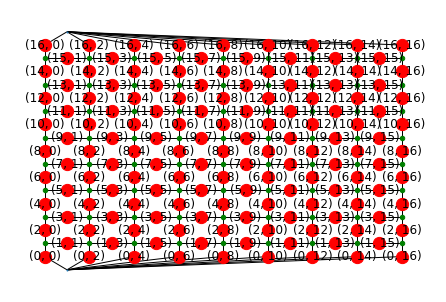

In [52]:
pos = {(x,y):(y,x) for x,y in lattice.nodes()}
# nx.draw(lattice, pos=pos, node_size = 3) edgelist=vertex_edges,
nx.draw(lattice, pos=pos, node_size = 1)
nx.draw(lattice_qubits, with_labels=True, pos=pos, node_color = 'r', node_size = 150)
nx.draw(lattice_vertex, pos=pos, node_color = 'g', node_size = 20)
# nx.draw(lattice_plaquette, pos=pos, node_color = 'b', node_size = 10)

Before we begin let's compute all-pairs shortest paths

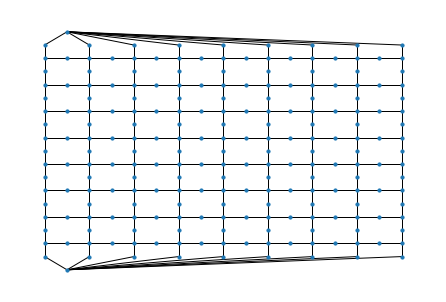

In [53]:
shortest_paths = dict(nx.shortest_path(lattice_vis))
shortest_paths_length = dict(nx.shortest_path_length(lattice, weight='weight'))

boundaries = [(q[0]+0.5, q[1]+1) for q in vertex_coordinates.keys()]
# syndrome_edges = [(p1, p2, {'weight': len(shortest_paths[p1][p2])-1}) for i,p1 in enumerate(vertex_coordinates.keys()) for j,p2 in enumerate(vertex_coordinates.keys()) if i>j]
boundary_edges = [(s, b, {"weight" : min(shortest_paths_length[s][terminals[0]], shortest_paths_length[s][terminals[1]])}) for s,b in zip(vertex_coordinates.keys(), boundaries)]
tunnel_edges = [(boundaries[i], boundaries[j], {"weight" : 0}) for j in range(len(boundaries)) for i in range(j)]

# lattice.add_nodes_from(boundaries)
# lattice.add_edges_from(boundary_edges+tunnel_edges)
pos = {(x,y):(y,x) for x,y in lattice.nodes()}
nx.draw(lattice, pos=pos, node_size=10)

# shortest_paths = dict(nx.all_pairs_shortest_path(lattice))
# lattice.add_edges_from(syndrome_edges)
pos = {(x,y):(y,x) for x,y in lattice.nodes()}


In [54]:
shortest_path_to_boundary = {}
for q in vertex_coordinates:
    p0 = nx.shortest_path(lattice, q, terminals[0])
    p1 = nx.shortest_path(lattice, q, terminals[1])
    if len(p0) < len(p1):
        shortest_path_to_boundary[q] = p0
    else:
        shortest_path_to_boundary[q] = p1

Ok lets simulate catching Z errors. These will be caught by the vertex stabilizers

In [55]:
def bounds(q, w):
    x,y = q
    return x >= 0 and x < w and y >= 0 and y < w



def calculate_stabilizer_eigenvalues(w, qubits_flipped, vertex_coordinates):
    for k in vertex_coordinates.keys():
        vertex_coordinates[k] = 1
        # print(f"vertex = {k}", end=" -- ")
        for offs in [(1,0), (-1,0), (0,1), (0,-1)]:
            qubit = ((k[0]+offs[0]), (k[1]+offs[1]))
            # print(qubit, end=", ")
            if bounds(qubit,w) and qubits_flipped[qubit] == 1:
                vertex_coordinates[k] *= -1
        # print()

In [76]:
prob = 0.15 # Error rate for physical qubit

# Let's store two arrays for each offset grid of qubits
qubits_flipped = {qc: (0 if uniform()>prob else 1) for qc in qubit_coordinates}

# calculate stabilizer eigenvalues
calculate_stabilizer_eigenvalues(w, qubits_flipped, vertex_coordinates)
# print(vertex_coordinates)

Lets check if any of this makes sense

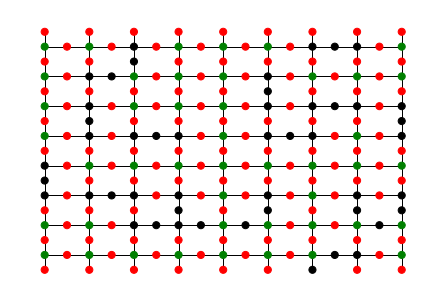

In [77]:
colour_qubits = ['red' if qubits_flipped[q] == 0 else 'black' for q in lattice_qubits]
colour_vertices = ['green' if vertex_coordinates[q] == 1 else 'black' for q in lattice_vertex]
nx.draw(lattice_vis, pos=pos, edgelist=vertex_edges, node_size = 1)
nx.draw_networkx_nodes(lattice_qubits, pos=pos, node_color=colour_qubits, node_size=50)
nx.draw_networkx_nodes(lattice_vertex, pos=pos, node_color=colour_vertices, node_size=50);

In the above graph, physical qubits that are not flipped are red, and the ones that are flipped are black. For the vertices, green means that the eigenvalue is +1 and black means that the eigenvalue is -1. We can see that the flipped physical qubits form a chain that joins two syndromes (ie vertices with -1 eigenvalue)

To make networkx compute MWPM we must do some cleanup - we must construct the graph of just the syndromes

In [78]:
syndromes = [q for q in lattice_vertex if vertex_coordinates[q] == -1]
boundaries = [(q[0]+0.5, q[1]+1) for q in syndromes]
syndrome_edges = [(p1, p2, {'weight': len(shortest_paths[p1][p2])-1}) for i,p1 in enumerate(syndromes) for j,p2 in enumerate(syndromes) if i>j]
boundary_edges = [(s, b, {"weight" : min(shortest_paths_length[s][terminals[0]], shortest_paths_length[s][terminals[1]])}) for s,b in zip(syndromes, boundaries)]
tunnel_edges = [(boundaries[i], boundaries[j], {"weight" : 0}) for j in range(len(boundaries)) for i in range(j)]

syndrome_G = nx.Graph()
syndrome_G.add_nodes_from(syndromes+boundaries)
syndrome_G.add_edges_from(syndrome_edges+boundary_edges+tunnel_edges)
pos_syn = {(x,y):(y,x) for x,y in syndrome_G.nodes()}
# nx.draw(syndrome_G, pos=pos_syn, with_labels=True)
# nx.draw_networkx_edge_labels(syndrome_G, pos=pos_syn, edge_labels=nx.get_edge_attributes(syndrome_G,'weight'));

In [79]:
def get_path(shortest_path_to_boundary, shortest_paths, s, e):
    if type(s[0]) == float and type(e[0]) == float:
        return []
    if type(s[0]) == float:
        return shortest_path_to_boundary[e]
    if type(e[0]) == float:
        return shortest_path_to_boundary[s]
    return shortest_paths[s][e]

def qubits_from_path(qubit_coordinates, nodes):
    return [n for n in nodes if n in qubit_coordinates]


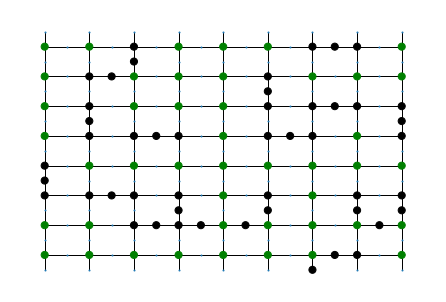

In [80]:

matching = list(nx.min_weight_matching(syndrome_G, weight='weight'))


syndrome_corrections = list(itertools.chain.from_iterable(qubits_from_path(qubit_coordinates, get_path(shortest_path_to_boundary, shortest_paths, s,e)) for s,e in matching))
# colour_qubits_correction = ['red' if qubits_flipped[q] == 0 else 'purple' for q in lattice_qubits]
size_qubits_correction = [0 if qubits_flipped[q] == 0 else 50 for q in lattice_qubits]
nx.draw(lattice_vis, pos=pos, edgelist=vertex_edges, node_size = 1)
nx.draw_networkx_nodes(lattice_qubits, pos=pos, node_color='black', node_size=size_qubits_correction)
nx.draw_networkx_nodes(lattice_vertex, pos=pos, node_color=colour_vertices, node_size=50);

Calculate corrected system

In [81]:
for q in syndrome_corrections:
    qubits_flipped[q] = 1-qubits_flipped[q]
calculate_stabilizer_eigenvalues(w, qubits_flipped, vertex_coordinates)    

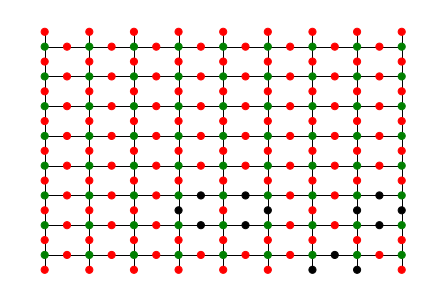

In [82]:
colour_qubits = ['red' if qubits_flipped[q] == 0 else 'black' for q in lattice_qubits]
colour_vertices = ['green' if vertex_coordinates[q] == 1 else 'black' for q in lattice_vertex]
nx.draw(lattice_vis, pos=pos, edgelist=vertex_edges, node_size = 1)
nx.draw_networkx_nodes(lattice_qubits, pos=pos, node_color=colour_qubits, node_size=50)
nx.draw_networkx_nodes(lattice_vertex, pos=pos, node_color=colour_vertices, node_size=50)

qubit connectivity graph to check for loop

In [83]:
corrected_flipped_qubits = [q for q in qubit_coordinates if qubits_flipped[q]]

0

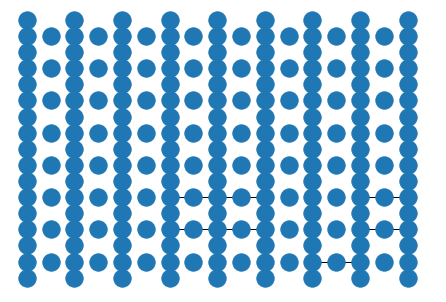

In [84]:
checkG = lattice.subgraph(corrected_flipped_qubits+list(vertex_coordinates.keys())).copy()
checkG.add_nodes_from(qubit_coordinates)
nx.draw(checkG, pos=pos)
top_row = [(w-1, 2*n) for n in range(l)]
bottom_row = [(0, 2*n) for n in range(l)]
# print(top_row, bottom_row)
links = 0
for t in top_row:
    for b in bottom_row:
        if nx.has_path(checkG, t,b):
            links += 1
links

In [65]:
def test(length, prob, reps):
    l = length
    w = 2*l-1
    lattice = nx.Graph()
    lattice.add_nodes_from([(n, m) for n in range(w) for m in range(w) if not (n%2 == 0 and m%2 == 1)])
    # all horizontal/vertical edges
    vertex_edges = [((2*n+1, m), (2*n+1, (m+1)%w)) for n in range(l-1) for m in range(2*l-2)] + \
                            [((n, 2*m), ((n+1)%w, 2*m)) for n in range(2*l-2) for m in range(l)]
    lattice.add_edges_from(vertex_edges)

    terminals = [(-1,1), (w, 1)]
    lattice.add_nodes_from(terminals)
    terminal_edges = [(terminals[0], (0, 2*n), {"weight" : 1}) for n in range(l)] + [(terminals[1], (w-1, 2*n), {"weight" : 1}) for n in range(l)]
    lattice.add_edges_from(terminal_edges)

    qubit_coordinates = [(2*n, 2*m) for n in range(l) for m in range(l)] + [(2*n+1, 2*m+1) for n in range(l-1) for m in range(l-1)]
    vertex_coordinates = {(2*n+1, 2*m):1 for n in range(l-1) for m in range(l)}
    # lattice_qubits = lattice.subgraph(qubit_coordinates)
    lattice_vertex = lattice.subgraph(list(vertex_coordinates.keys()))
    lattice_vis = lattice.subgraph(qubit_coordinates + list(vertex_coordinates.keys()))
    shortest_paths = dict(nx.shortest_path(lattice_vis))
    shortest_paths_length = dict(nx.shortest_path_length(lattice, weight='weight'))


    boundaries = [(q[0]+0.5, q[1]+1) for q in vertex_coordinates.keys()]
    boundary_edges = [(s, b, {"weight" : min(shortest_paths_length[s][terminals[0]], shortest_paths_length[s][terminals[1]])}) for s,b in zip(vertex_coordinates.keys(), boundaries)]
    tunnel_edges = [(boundaries[i], boundaries[j], {"weight" : 0}) for j in range(len(boundaries)) for i in range(j)]

    shortest_path_to_boundary = {}
    for q in vertex_coordinates:
        p0 = nx.shortest_path(lattice, q, terminals[0])
        p1 = nx.shortest_path(lattice, q, terminals[1])
        if len(p0) < len(p1):
            shortest_path_to_boundary[q] = p0
        else:
            shortest_path_to_boundary[q] = p1

    time = 0
    for _ in range(reps):
        life = 0
        no_error = True
        while no_error:
            qubits_flipped = {qc: 0 for qc in qubit_coordinates}
            for q in qubits_flipped.keys():
                if uniform()<prob:
                    qubits_flipped[q] = 1-qubits_flipped[q]
            calculate_stabilizer_eigenvalues(w, qubits_flipped, vertex_coordinates)

            syndromes = [q for q in lattice_vertex if vertex_coordinates[q] == -1]
            boundaries = [(q[0]+0.5, q[1]+1) for q in syndromes]
            syndrome_edges = [(p1, p2, {'weight': len(shortest_paths[p1][p2])-1}) for i,p1 in enumerate(syndromes) for j,p2 in enumerate(syndromes) if i>j]
            boundary_edges = [(s, b, {"weight" : min(shortest_paths_length[s][terminals[0]], shortest_paths_length[s][terminals[1]])}) for s,b in zip(syndromes, boundaries)]
            tunnel_edges = [(boundaries[i], boundaries[j], {"weight" : 0}) for j in range(len(boundaries)) for i in range(j)]

            syndrome_G = nx.Graph()
            syndrome_G.add_nodes_from(syndromes+boundaries)
            syndrome_G.add_edges_from(syndrome_edges+boundary_edges+tunnel_edges)

            matching = list(nx.min_weight_matching(syndrome_G, weight='weight'))
            syndrome_corrections = list(itertools.chain.from_iterable(qubits_from_path(qubit_coordinates,get_path(shortest_path_to_boundary, shortest_paths,s,e)) for s,e in matching))

            for q in syndrome_corrections:
                qubits_flipped[q] = 1-qubits_flipped[q]
            calculate_stabilizer_eigenvalues(w,qubits_flipped, vertex_coordinates) 

            corrected_flipped_qubits = [q for q in qubit_coordinates if qubits_flipped[q]]

            checkG = lattice.subgraph(corrected_flipped_qubits+list(vertex_coordinates.keys())).copy()
            checkG.add_nodes_from(qubit_coordinates)
            top_row = [(w-1, 2*n) for n in range(l)]
            bottom_row = [(0, 2*n) for n in range(l)]

            links = 0
            for t in top_row:
                for b in bottom_row:
                    if nx.has_path(checkG, t,b):
                        links += 1
            if links%2 == 1:
                # print(links)
                no_error = False
            else:
                life += 1
        time += life
    return time/reps


Iterate many times

In [66]:
test(9, 0.14, 100)

2.03